In [1]:
!pip install fredapi
!pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [55]:
%env MKL_THREADING_LAYER=GNU

from fredapi import Fred

import pandas as pd
import numpy as np
from scipy import stats

# import pandas_datareader.data as web

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

import pymc3 as pm
import arviz
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import os
sns.set_style('whitegrid')

env: MKL_THREADING_LAYER=GNU


In [3]:
os.
fred = Fred(fred_api_key='1afc3162f75a055edf1d1a95529096cf')

### 경기 침체를 예측을 위한 변수

- 재무부 수익률 곡선의 장기 스프레드 곡선은 재무부 10년 수익률과 3개월
- 미시건 대학의 소비심리 지표
- 국가 재정 상황 지수(NFCI)
- NFCI 비금융 레버리지 하위 지수.

In [62]:
# indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT','UNRATE','IC4WSA','PAYEMS','AWHAETP', 'CES3000000004','HOUST','MSPNHSUS','TOTALSA']
# var_names = ['Recession', 'yield_curve', 'financial_conditions', 'leverage', 'sentiment','Unemployment', 'Initial_Claims', 'Employees_Nonfarm', 'working_time', 'Overtime','Housing_Starts','Median_Price_for_New_Houses','Total_Vehicle_Sales']

In [24]:
indicators = ['JHDUSRGDPBR', 'T10Y3M', 'NFCI', 'NFCINONFINLEVERAGE','UNRATE','IC4WSA','PAYEMS','AWHAETP','TOTALSA']
var_names = ['Recession', 'yield_curve', 'financial_conditions', 'leverage', 'Unemployment', 'Initial_Claims', 'Employees_Nonfarm', 'working_time','Total_Vehicle_Sales']

features = var_names[1:]
label = var_names[0]

In [25]:
data = {symbol:fred.get_series(symbol, observation_start='1980') for symbol in indicators}
data = pd.DataFrame.from_dict(data).ffill().resample('M').last().dropna()

In [26]:
data.columns = var_names
data.loc[:, features] = scale(data.loc[:, features])  # features 데이터 (x 변수)에 대해서 스케일링 진행

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2006-03-31 to 2023-07-31
Freq: M
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Recession             209 non-null    float64
 1   yield_curve           209 non-null    float64
 2   financial_conditions  209 non-null    float64
 3   leverage              209 non-null    float64
 4   Unemployment          209 non-null    float64
 5   Initial_Claims        209 non-null    float64
 6   Employees_Nonfarm     209 non-null    float64
 7   working_time          209 non-null    float64
 8   Total_Vehicle_Sales   209 non-null    float64
dtypes: float64(9)
memory usage: 16.3 KB


### Quick exploration

- 상호 정보량을 계산하여 Recession 변수와 각 feature 변수와 관계를 확인한다.
- 월별 시프트(shift)를 통해 미래 월의 label 값을 예측
- 2년(24개월) 동안의 데이터를 대상으로 하며, 각 월에 대해 상호 정보량을 계산하고 결과를 mi 리스트에 추가.
- 이를 통해 각 월별로 label과 다른 변수들 간의 관계를 파악하고, 예측 모델 또는 특성 선택(feature selection) 등의 작업을 수행
- label: Recession 여부를 순차적으로 shift한다. 이는 해당 시점이 shift 되는 Recession과 얼마나 관련이 있는 변수 인지 확인한다.

#### 상호 정보량(mutual information) 사용 예:

상호 정보량을 사용하여 주식 가격(y)과 특정 요소(x0) 간의 관계를 평가할 수 있다. \
예를 들어, x0는 과거 거래량이라고 가정. \
상호 정보량을 계산하여 y와 x0 사이의 상호 의존성을 확인할 수 있다. \
이를 통해 과거 거래량과 주식 가격 간의 어떤 종류의 관계가 있는지 알 수 있다. \
예를 들어, 상호 정보량이 높을 경우, 과거 거래량과 주식 가격 간에 강한 상호 의존성이 있을 수 있다. \
이는 과거 거래량이 주식 가격을 예측하는 데 중요한 변수일 수 있다

#### 상관 관계(correlation) 사용 예:

상관 계수를 사용하여 주식 가격(y)과 다른 요소들 간의 선형 관계를 평가할 수 있다. \
예를 들어, x0는 과거 거래량, x1은 과거 주식 수익률이라고 가정 \
상관 계수를 계산하여 x0와 y 사이의 선형 상관 관계를 확인할 수 있다. \
또한, x0와 x1 사이의 선형 상관 관계도 확인할 수 있다. \
상관 계수가 양수라면, 두 변수 간에 양의 선형 상관관계가 있음. 반대로 음수라면, 음의 선형 상관관계가 있음

In [28]:
mi = []
months = list(range(1, 25))  # 2년 동안의 월을 나타낸다.
for month in months:
    df_copy = data.copy()  #원본 데이터를 카피
    df_copy[label] = df_copy[label].shift(-month)  #month만큼 앞으로 시프트, 예를 들어 month가 1인 경우, label 열의 값은 한 달 앞으로 이동
    df_copy = df_copy.dropna()  #결측치 제거
    mi.append(mutual_info_classif(df_copy.loc[:, features], df_copy[label]))  # df_copy.loc[:, features]에서 df_[label] 값을 기준으로 상호 정보량(mutual information)을 계산
mi = pd.DataFrame(mi, columns=features, index=months)

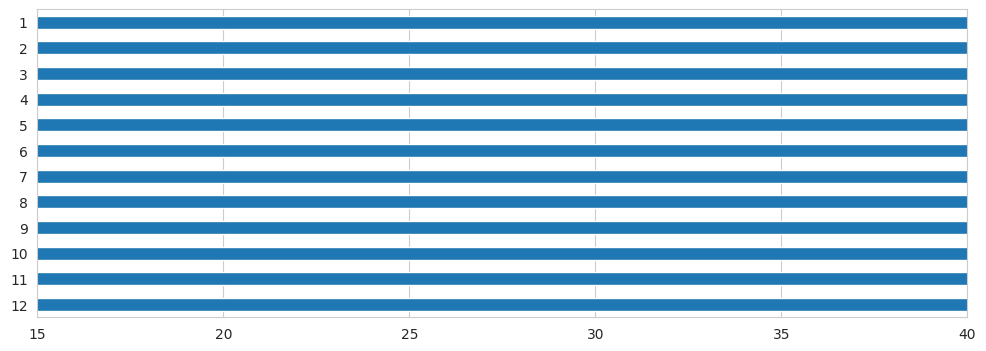

In [29]:
mi.sum(1).mul(100).iloc[:12].sort_index(ascending=False).plot.barh(figsize=(12, 4), xlim=(15, 40));

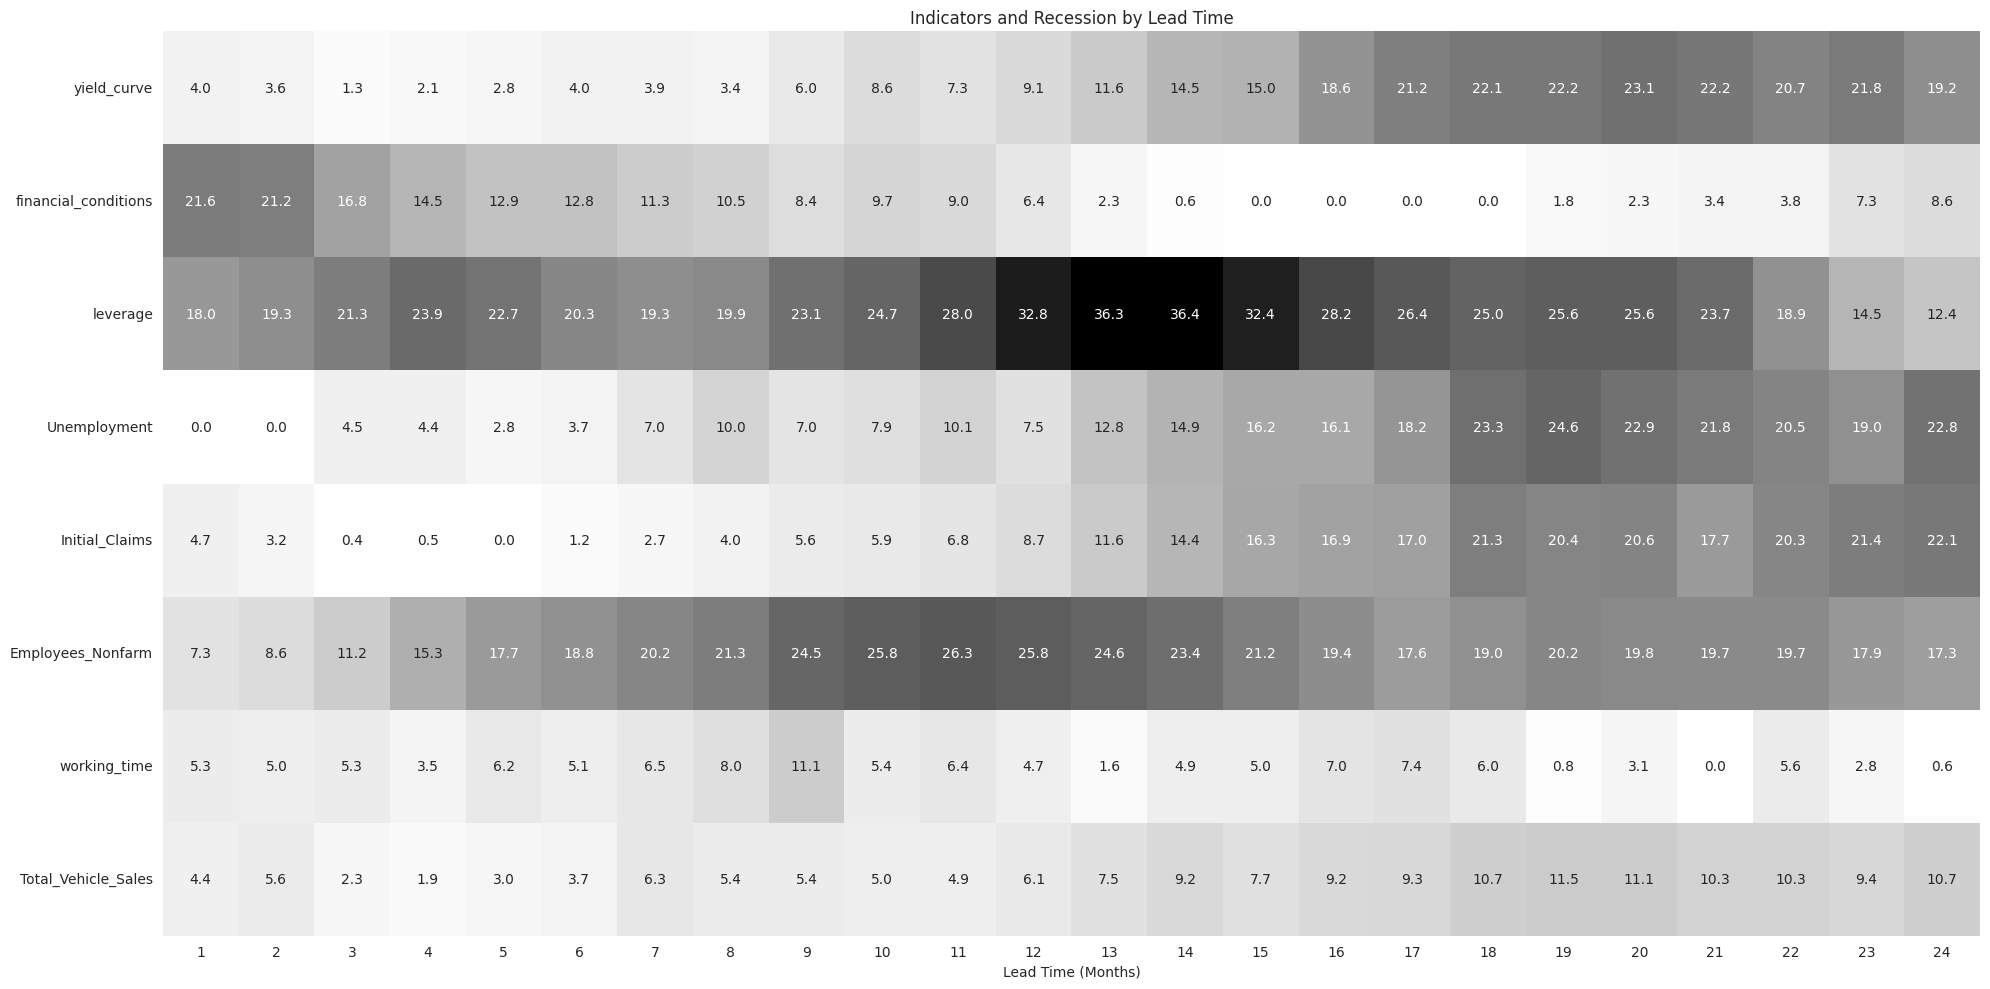

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(mi.T*100, cmap='Greys', ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
# ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
ax.set_title('Indicators and Recession by Lead Time')
fig.tight_layout();

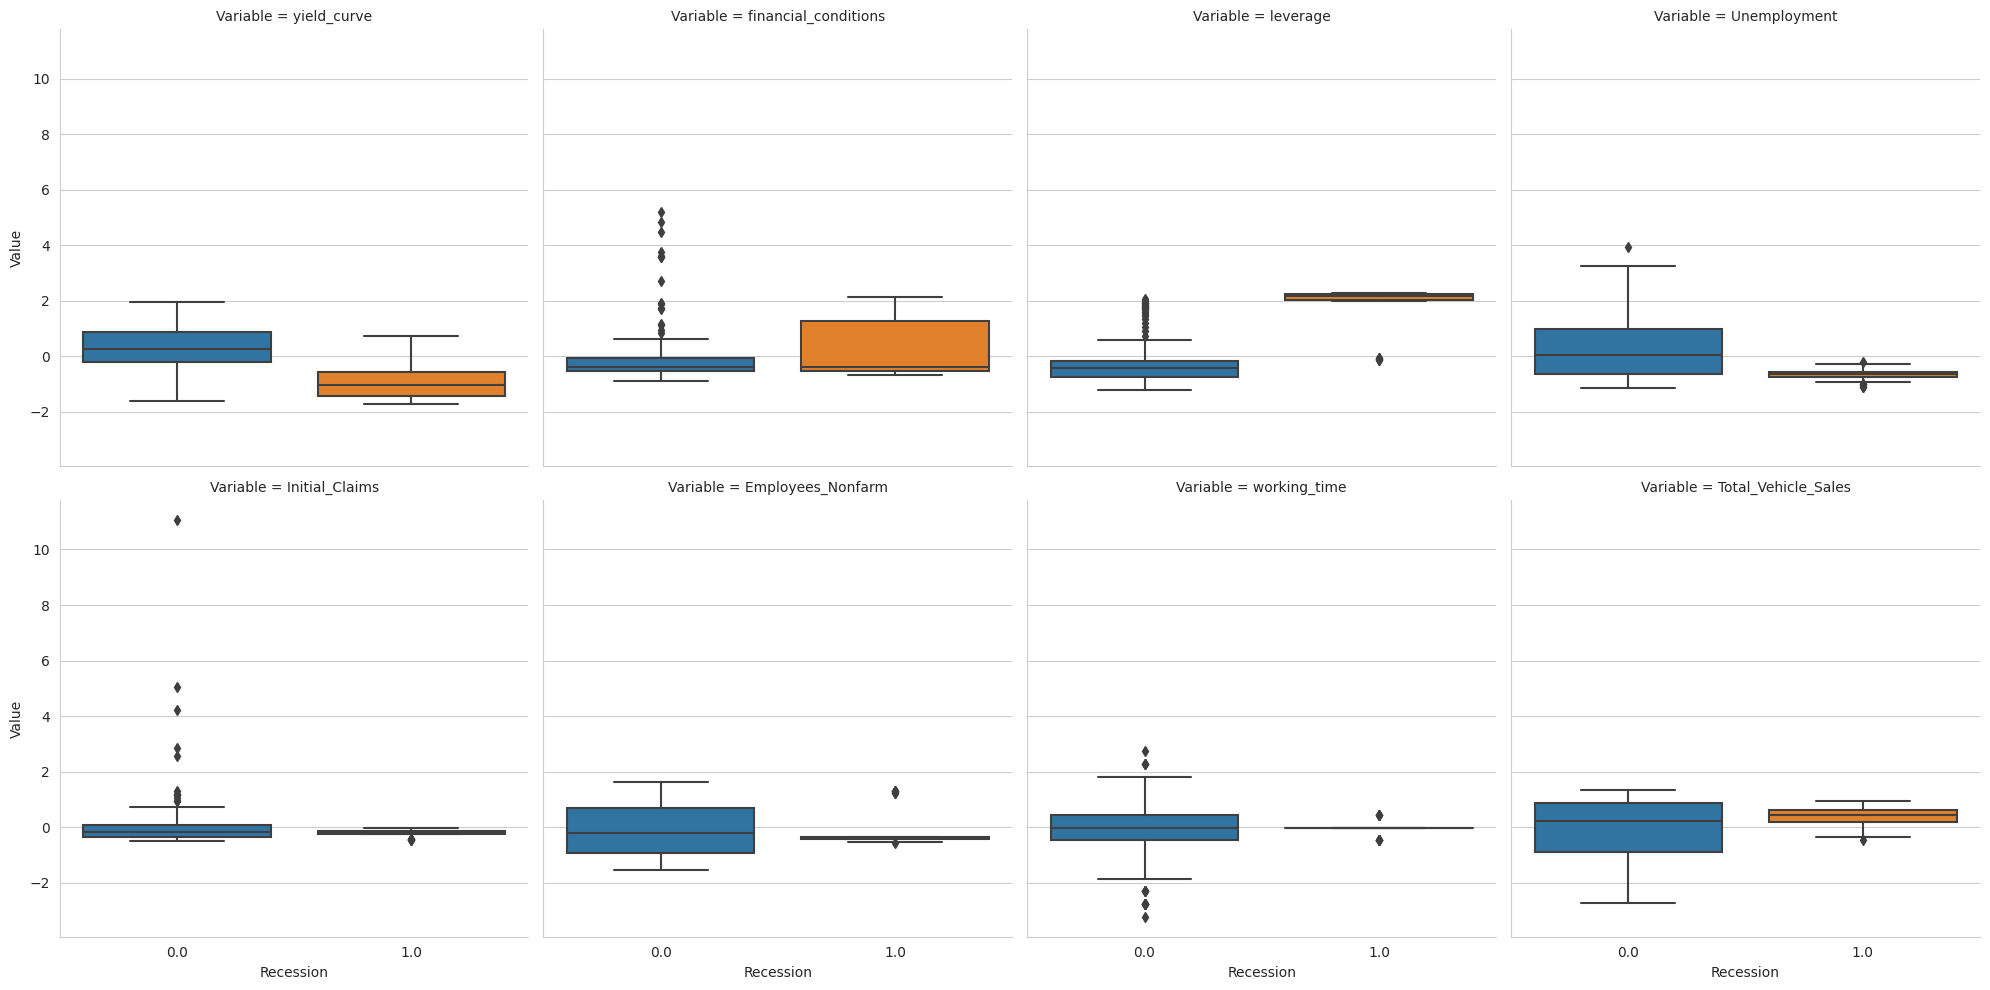

In [31]:
data[label] = data[label].shift(-12)
data = data.dropna()
data_ = pd.melt(data, id_vars='Recession').rename(columns=str.capitalize)
g = sns.catplot(x='Recession', y='Value', col='Variable', data=data_, kind='box', col_wrap=4);
plt.tight_layout();

- 분석이 용이하도록 y와 x 변수로 데이터 분리

In [32]:
X = data.loc[:, features]
y = data[label]
y.value_counts()

0.0    170
1.0     27
Name: Recession, dtype: int64

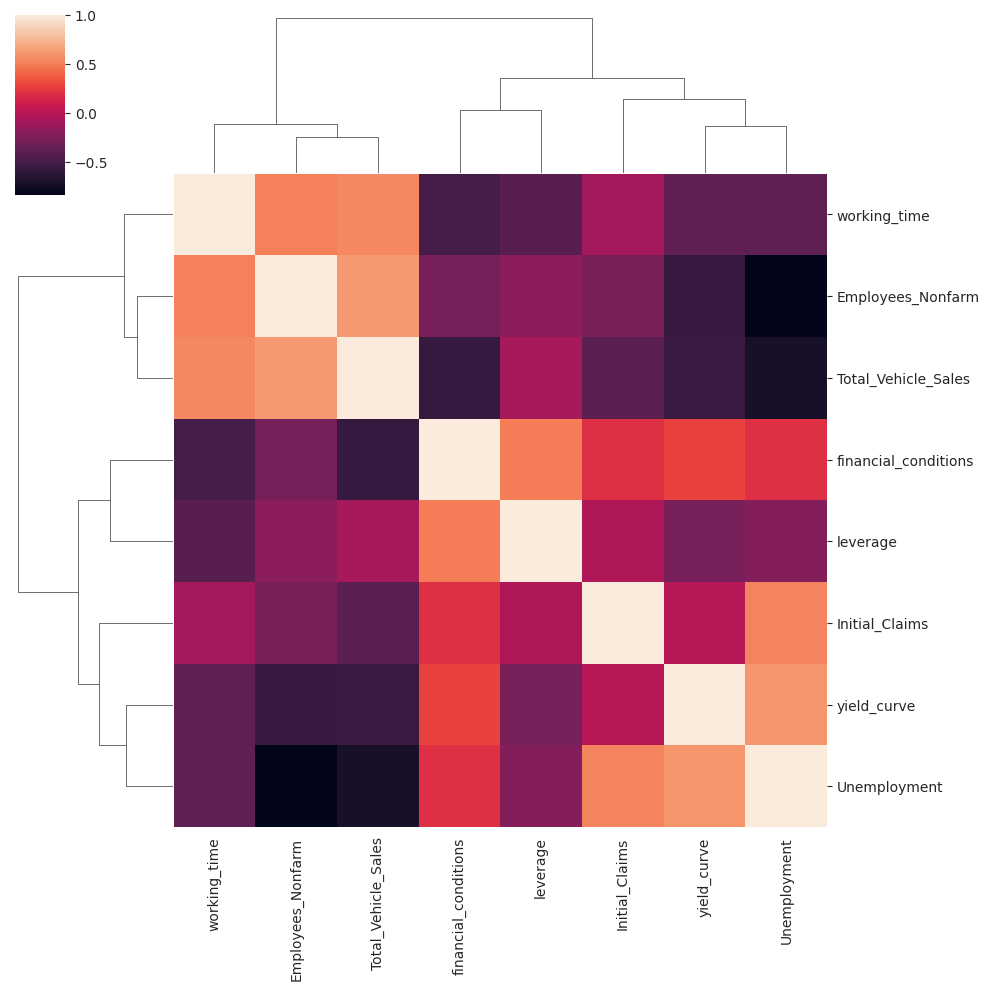

In [33]:
sns.clustermap(X.corr(), vmin=-1, vmax=1, cmap='coolwarm')

### 모델링

In [34]:

full_model =  y.name + " ~ " +" + ".join(X.columns)
full_model

'Recession ~ yield_curve + financial_conditions + leverage + Unemployment + Initial_Claims + Employees_Nonfarm + working_time + Total_Vehicle_Sales'

In [35]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(full_model,
                            data,
                            family=pm.glm.families.Binomial())

We recommend to instead use Bambi https://bambinos.github.io/bambi/


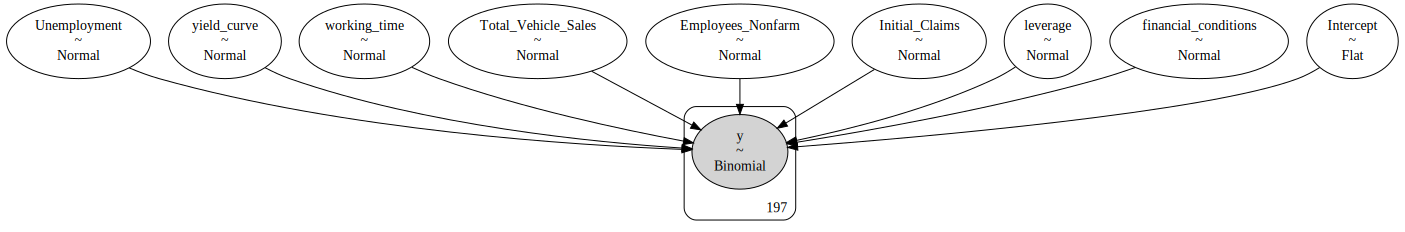

In [36]:
pm.model_to_graphviz(logistic_model)

## MAP Estimate

In [37]:
with logistic_model:
    map_estimate = pm.find_MAP()

In [38]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.069703
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  197
Model:                          Logit   Df Residuals:                      188
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Jul 2023   Pseudo R-squ.:                  0.8256
Time:                        06:08:59   Log-Likelihood:                -13.731
converged:                       True   LL-Null:                       -78.718
Covariance Type:            nonrobust   LLR p-value:                 2.866e-24
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -25.5490     11.294     -2.262      0.024     -47.685      -3.41

In [40]:
def print_map(result):
    return pd.Series({k: np.asscalar(v) for k, v in result.items()})
print_map(map_estimate)

<ipython-input-40-13404a132ffe>:2: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return pd.Series({k: np.asscalar(v) for k, v in result.items()})


Intercept              -25.546888
yield_curve              1.437679
financial_conditions    -4.810014
leverage                27.161567
Unemployment            18.195490
Initial_Claims          -5.506356
Employees_Nonfarm       33.181667
working_time             3.794024
Total_Vehicle_Sales      1.551249
dtype: float64

In [41]:
result.params

Intercept              -25.549012
yield_curve              1.438297
financial_conditions    -4.813201
leverage                27.169763
Unemployment            18.215617
Initial_Claims          -5.528961
Employees_Nonfarm       33.192482
working_time             3.793892
Total_Vehicle_Sales      1.550743
dtype: float64

## 마르코프 체인

In [42]:
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')
    plt.tight_layout();

In [44]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [45]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 yield_curve ~ Normal,
 financial_conditions ~ Normal,
 leverage ~ Normal,
 Unemployment ~ Normal,
 Initial_Claims ~ Normal,
 Employees_Nonfarm ~ Normal,
 working_time ~ Normal,
 Total_Vehicle_Sales ~ Normal,
 y ~ Binomial]

In [46]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr

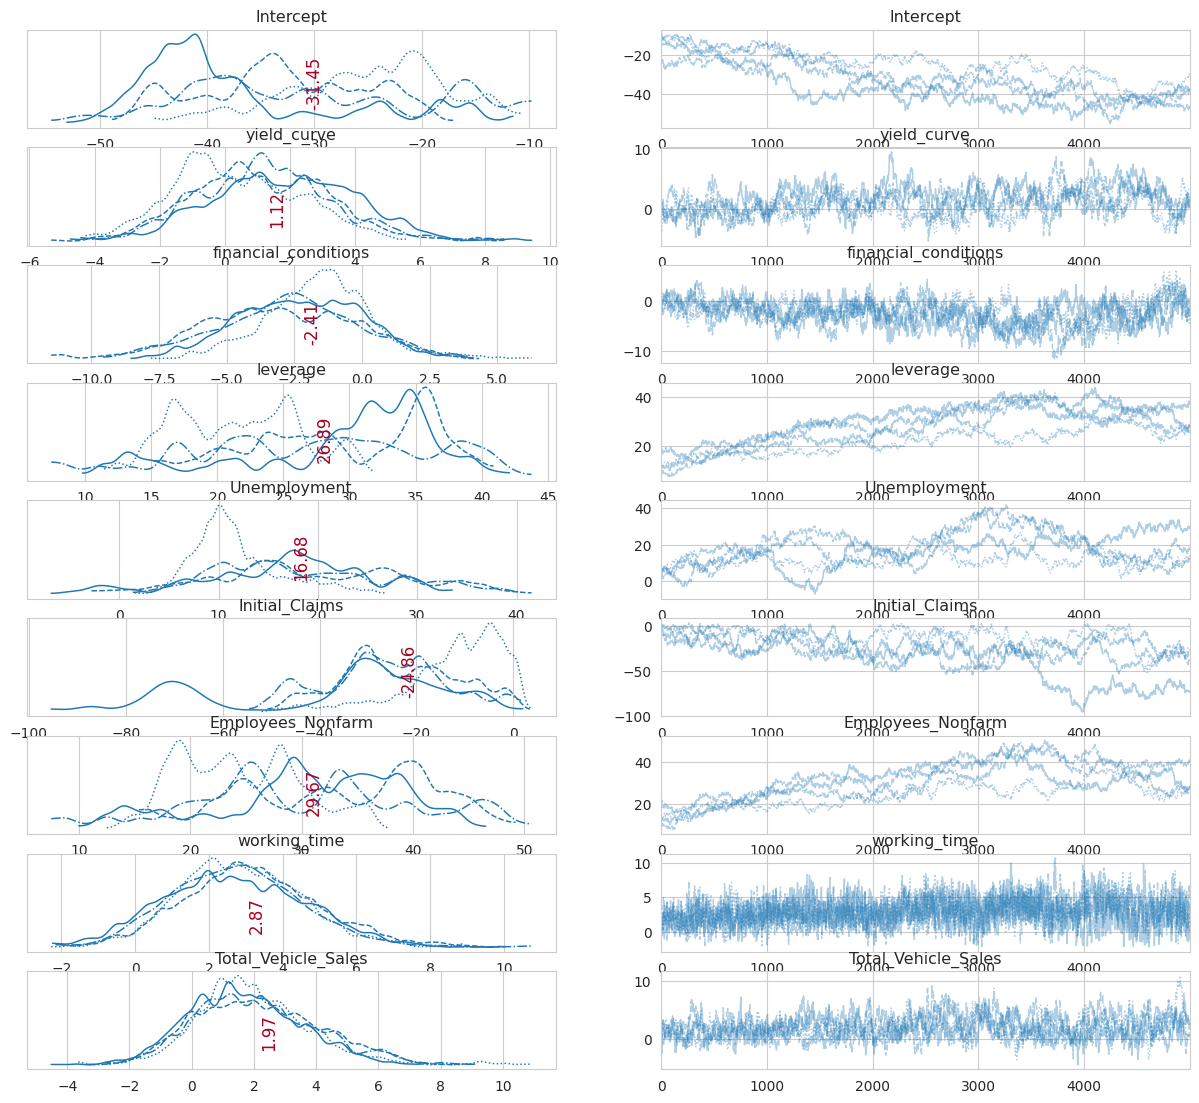

In [47]:
plot_traces(trace_mh, burnin=0)

In [48]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             20000 non-null  float64
 1   yield_curve           20000 non-null  float64
 2   financial_conditions  20000 non-null  float64
 3   leverage              20000 non-null  float64
 4   Unemployment          20000 non-null  float64
 5   Initial_Claims        20000 non-null  float64
 6   Employees_Nonfarm     20000 non-null  float64
 7   working_time          20000 non-null  float64
 8   Total_Vehicle_Sales   20000 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [49]:
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1395: FutureWarning: Starting from MultiTrace objects is not supported in v4.
  warnings.warn("Starting from MultiTrace objects is not supported in v4.", FutureWarning)


ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr

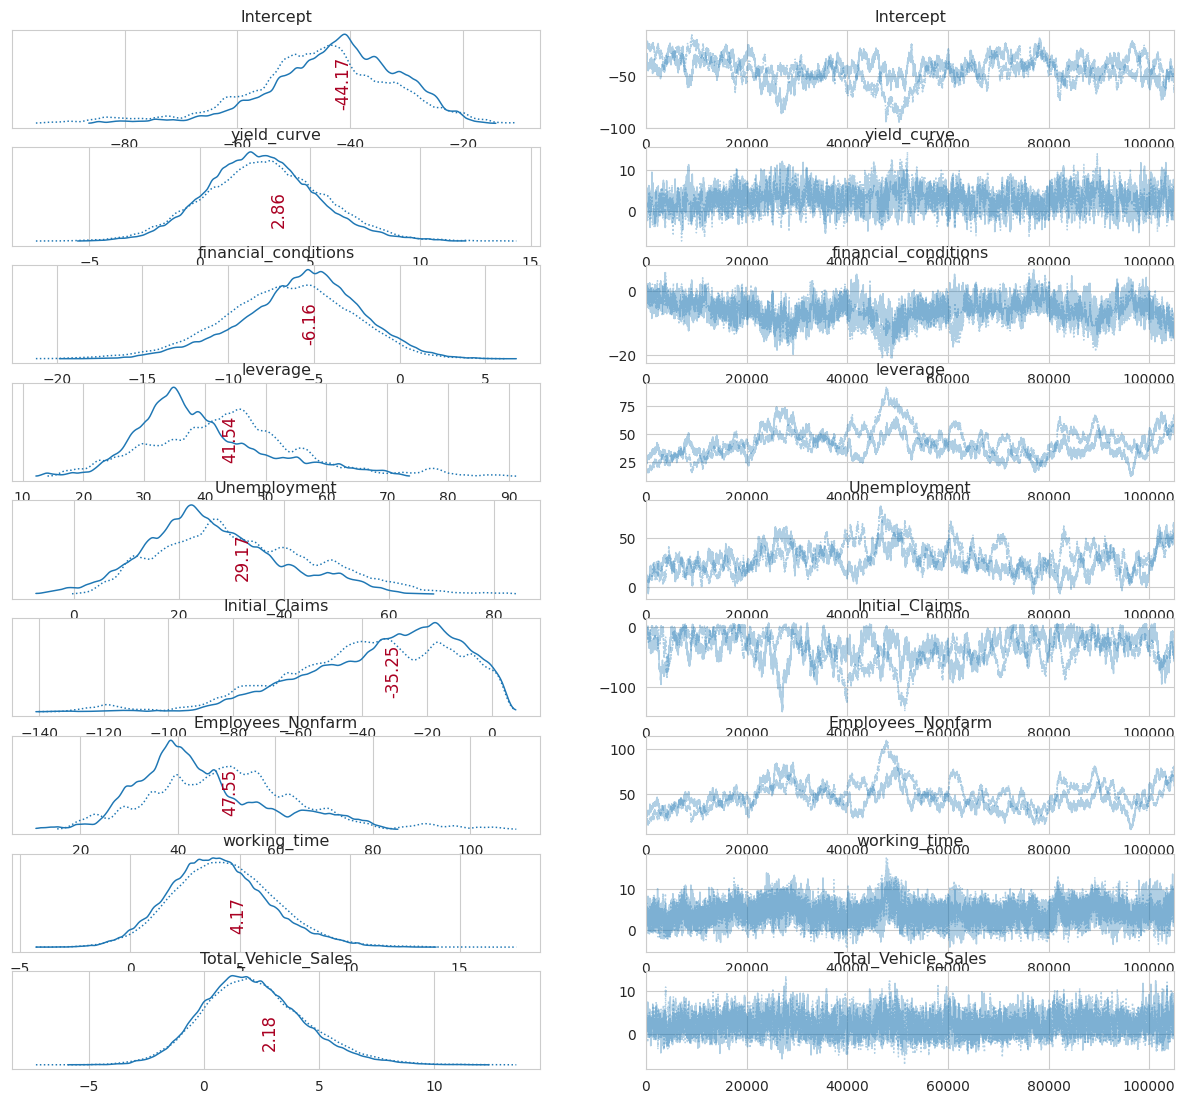

In [53]:
plot_traces(trace_mh, burnin=0)

In [51]:
arviz.summary(trace_mh)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-44.169,12.375,-66.126,-20.527,2.176,1.583,34.0,42.0,1.02
yield_curve,2.857,2.585,-2.039,7.731,0.221,0.162,140.0,323.0,1.00
financial_conditions,-6.159,3.618,-13.292,0.337,0.498,0.358,54.0,132.0,1.03
leverage,41.540,11.911,21.229,65.168,2.304,1.647,28.0,41.0,1.04
Unemployment,29.167,13.996,5.200,55.963,2.703,1.933,27.0,48.0,1.05
Initial_Claims,-35.253,24.814,-78.022,3.837,4.272,3.047,35.0,117.0,1.03
Employees_Nonfarm,47.545,14.688,22.745,75.644,2.696,1.925,31.0,73.0,1.04
working_time,4.175,2.315,-0.101,8.594,0.195,0.138,144.0,371.0,1.01
Total_Vehicle_Sales,2.179,2.231,-1.860,6.478,0.078,0.055,784.0,2395.0,1.00


In [52]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=1,
                           random_seed=42)

AssertionError: ignored

In [ ]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

In [ ]:
plot_traces(trace_NUTS, burnin=0)

In [ ]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains,
                           cores=1,
                           random_seed=42)

In [ ]:
plot_traces(trace_NUTS, burnin=1000)

In [ ]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

In [ ]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

In [ ]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False);

In [ ]:
model = smf.logit(formula=full_model, data=data)
result = model.fit()
print(result.summary())

In [ ]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

In [ ]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params)

In [ ]:
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub

In [ ]:
b = trace_NUTS['yield_curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [ ]:
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

In [ ]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'yield_curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [ ]:
with logistic_model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=100000,
                    callbacks=[callback])

In [ ]:
trace_advi = approx.sample(10000)

In [ ]:
arviz.summary(trace_advi)

### 에너지 plot

In [ ]:
arviz.plot_energy(trace_NUTS);

### Forest Plot

In [ ]:
arviz.plot_forest(trace_NUTS);

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
arviz.plot_forest(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

arviz.plot_energy(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout();

### Posterior Predictive Checks

PPCs are very useful for examining how well a model fits the data. They do so by generating data from the model using parameters from draws from the posterior. We use the function pm.sample_ppc for this purpose and obtain n samples for each observation (the GLM module automatically names the outcome ‘y’):


PPC는 모형이 데이터를 얼마나 잘 적합시키는지 조사하는 데 매우 유용합니다. 이들은 후방에서 끌어온 모수를 사용하여 모형으로부터 데이터를 생성함으로써 이러한 작업을 수행합니다. 이 목적을 위해 pm.sample_pc 함수를 사용하고 각 관측치에 대해 n개의 샘플을 얻습니다(GLM 모듈은 결과 이름을 'y'로 자동 지정함).

In [ ]:
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [ ]:
ppc['y'].shape

In [ ]:
y_score = np.mean(ppc['y'], axis=0)

In [ ]:
roc_auc_score(y_score=np.mean(ppc['y'], axis=0),
              y_true=data.recession)

## Prediction
Follows PyMC3 [docs](https://docs.pymc.io/notebooks/posterior_predictive.html)

Predictions use theano’s shared variables to replace the training data with test data before running posterior predictive checks. To facilitate visualization, we create a variable with a single predictor hours, create the train and test datasets, and convert the former to a shared variable. Note that we need to use numpy arrays and provide a list of column labels:

예측은 사후 예측 검사를 실행하기 전에 훈련 데이터를 테스트 데이터로 대체하기 위해 Theano의 공유 변수를 사용합니다. 시각화를 용이하게 하기 위해 단일 예측 시간으로 변수를 만들고, 열차 및 테스트 데이터 세트를 만들고, 전자를 공유 변수로 변환한다. numpy 배열을 사용하고 열 레이블 목록을 제공해야 합니다.

### Train-test split

In [ ]:
X = data[['yield_curve']]
labels = X.columns
y = data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

### Create shared theano variable

In [ ]:
X_shared = theano.shared(X_train.values)

### Define logistic model

In [ ]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared,
               labels=labels,
               y=y_train,
               family=pm.glm.families.Binomial())

### Run NUTS sampler

In [ ]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000,
                           tune=1000,
                           chains=2,
                           cores=1,
                           init='adapt_diag')

### Replace shared variable with test set

We then run the sampler as before, and apply the pm.sample_ppc function to the resulting trace after replacing the train with test data:

그런 다음 이전과 같이 샘플러를 실행하고 테스트 데이터로 열차를 교체한 후 pm.sample_pc 함수를 결과 트레이스에 적용합니다.

In [ ]:
X_shared.set_value(X_test)

In [ ]:
ppc = pm.sample_posterior_predictive(pred_trace,
                                     model=logistic_model_pred,
                                     samples=100)

#### Check AUC Score

In [ ]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0),
              y_true=y_test)

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [ ]:
x = X_test.yield_curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout();

## MCMC Sampler Animation
The code is based on [MCMC visualization tutorial](https://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/).

### Setup

In [ ]:
# Number of MCMC iteration to animate.
burnin = 1000
samples = 1000

var1 = 'yield_curve'
var1_range = (trace_df[var1].min() * .95, trace_df[var1].max() * 1.05)

var2 = 'sentiment'
var2_range = (trace_df[var2].min() * .95, trace_df[var2].max() * 1.05)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(formula=full_model,
                            data=data,
                            family=pm.glm.families.Binomial())

### NUTS samples

In [ ]:
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

In [ ]:
with logistic_model:
    nuts_trace = pm.sample(draws=samples, tune=burnin,
                      init='adapt_diag',
                      chains=1)
    trace_df = pm.trace_to_dataframe(nuts_trace)
trace_df.to_csv('trace.csv', index=False)
trace_df = pd.read_csv('trace.csv')
print(trace_df.info())

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]


anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True);

# save
# anim.save('nuts.mp4', writer=writer)
# or display; either requres ffmpeg installation
HTML(anim.to_html5_video())

### Metropolis-Hastings samples

In [ ]:
with logistic_model:
    step = pm.Metropolis()
    mh_trace = pm.sample(draws=samples, tune=burnin,
                      step=step,
                      chains=1)
    trace_df = pm.trace_to_dataframe(mh_trace)

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(221, xlim=var1_range, ylim=(0, samples))
ax2 = fig.add_subplot(224, xlim=(0, samples), ylim=var2_range)
ax3 = fig.add_subplot(223, xlim=var1_range, ylim=var2_range,
                      xlabel=var1, ylabel=var2)

fig.subplots_adjust(wspace=0.0, hspace=0.0)
line1, = ax1.plot([], [], lw=1)
line2, = ax2.plot([], [], lw=1)
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1)
line4, = ax3.plot([], [], lw=1, alpha=.3)
line5, = ax3.plot([], [], 'k', lw=1)
line6, = ax3.plot([], [], 'k', lw=1)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
lines = [line1, line2, line3, line4, line5, line6]

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i):
    trace = trace_df.iloc[:i+1]
    idx = list(range(len(trace)))
    line1.set_data(trace[var1].iloc[::-1], idx)
    line2.set_data(idx, trace[var2].iloc[::-1])
    line3.set_data(trace[var1], trace[var2])
    line4.set_data(trace[var1], trace[var2])
    line5.set_data([trace[var1].iloc[-1], trace[var1].iloc[-1]], [trace[var2].iloc[-1], var2_range[1]])
    line6.set_data([trace[var1].iloc[-1], var1_range[1]], [trace[var2].iloc[-1], trace[var2].iloc[-1]])
    return lines

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=samples,
                               interval=5,
                               blit=True)

HTML(anim.to_html5_video())